Local Moran per candidate:   0%|          | 0/1 [00:00<?, ?it/s]

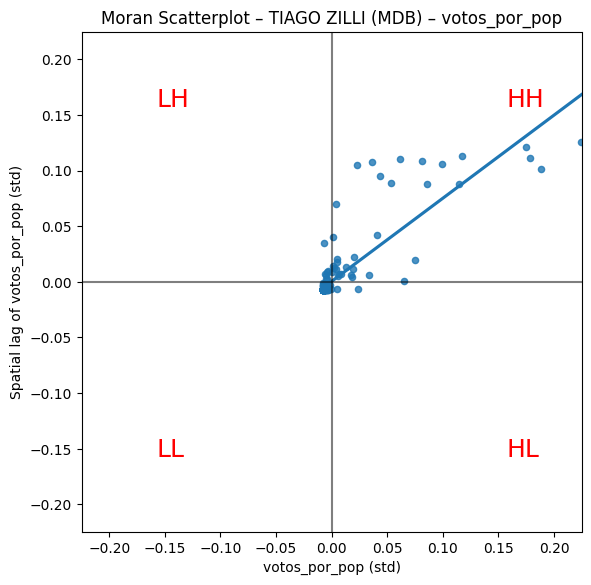

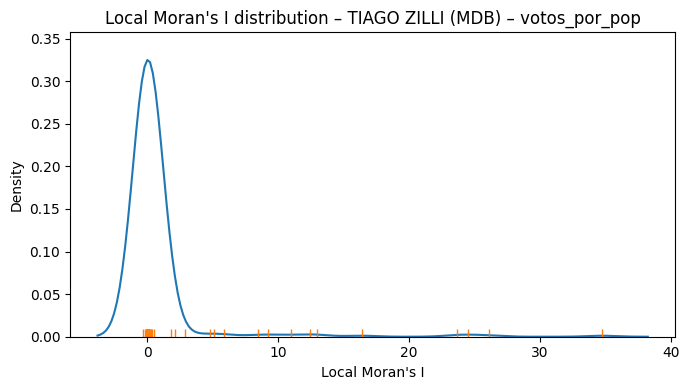

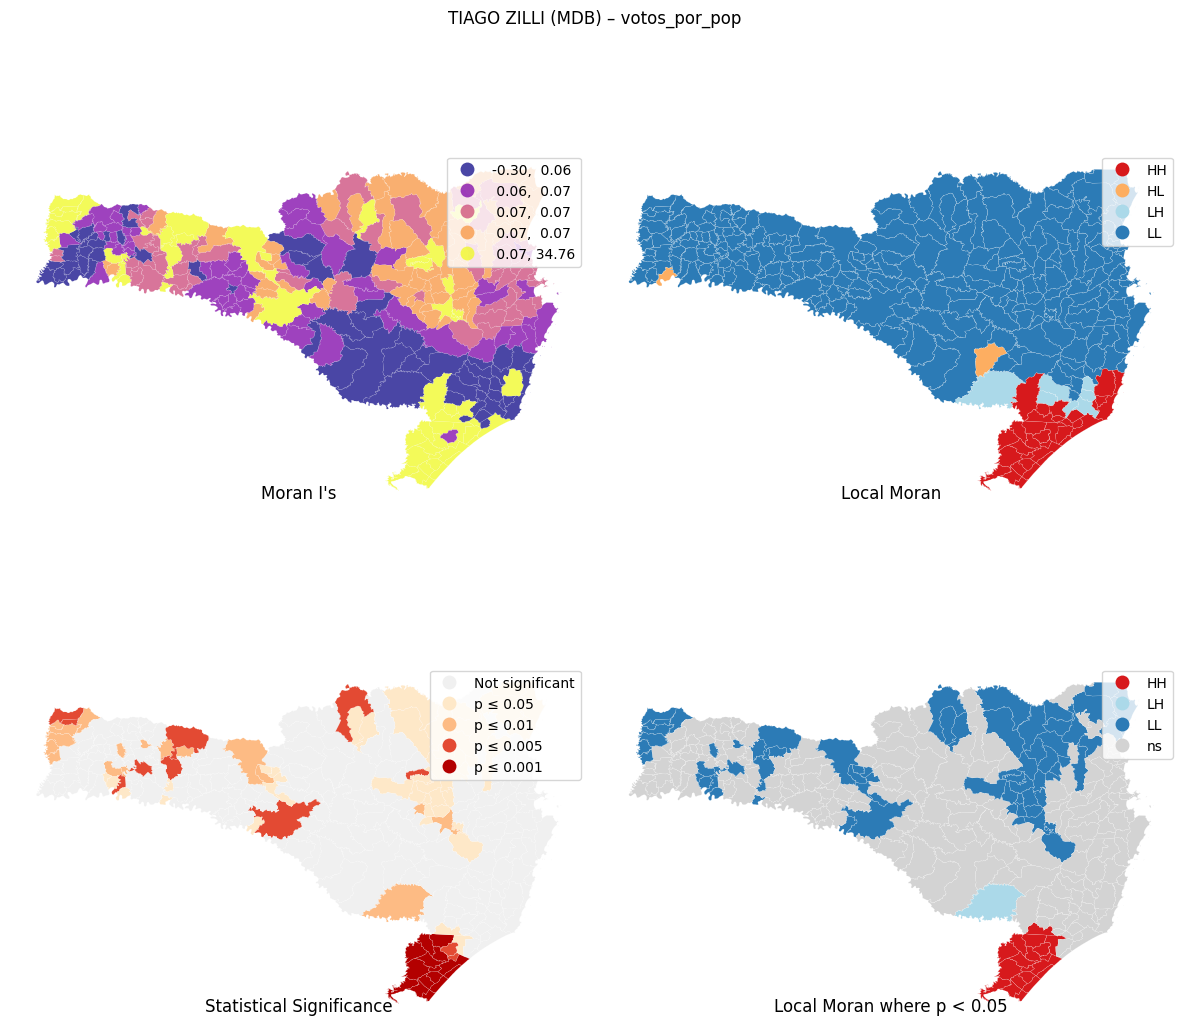

Local Moran per candidate: 100%|██████████| 1/1 [00:03<00:00,  3.33s/it]


In [10]:
# JUPYTER CELL — Local Moran (LISA) per candidate, using same style as
# "Local Spatial Autocorrelation — Geographic Data Science with Python"
#
# Requirements (install if needed):
#   pip install geopandas psycopg2-binary sqlalchemy libpysal esda splot seaborn tqdm matplotlib

import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from pysal.explore import esda
from pysal.lib import weights
from splot import esda as esdaplot

# Reuse your existing DB helpers
from calculate_morans import get_sqlalchemy_engine

# -------------------------------------------------------------------
# PARAMETERS
# -------------------------------------------------------------------

# List of candidates to analyze
CANDIDATES = [
    "240001605911",
    # add more sq_candidato as strings here
]

# Which attribute to use for local Moran: "qt_votos" or "votos_por_pop"
TARGET_COL = "votos_por_pop"

SQL_TEMPLATE = """
    SELECT
        id_municipio,
        nm_municipio,
        qt_votos,
        votos_por_pop,
        nr_votavel,
        nm_votavel,
        sq_candidato,
        sigla_partido,
        geom
    FROM eleicoes22.agg_eleicao_e_outras_bases_materialized
    WHERE sq_candidato = %(sq_candidato)s
      AND geom IS NOT NULL
"""

# -------------------------------------------------------------------
# DATA LOADING
# -------------------------------------------------------------------

def load_candidate_gdf(engine, sq_candidato: str) -> gpd.GeoDataFrame:
    gdf = gpd.read_postgis(
        SQL_TEMPLATE,
        engine,
        params={"sq_candidato": sq_candidato},
        geom_col="geom",
    )
    # Optional reprojection (similar to book’s example); comment out if not desired
    if gdf.crs is not None:
        gdf = gdf.to_crs(epsg=3857)
    return gdf


# -------------------------------------------------------------------
# LISA COMPUTATION (LOCAL MORAN)
# -------------------------------------------------------------------

def compute_local_moran(gdf: gpd.GeoDataFrame, col: str):
    """
    Returns (db, w, lisa)

    db: GeoDataFrame with standardized variable and spatial lag:
         - col_std
         - w_col
         - w_col_std
    w:  spatial weights object (KNN 8)
    lisa: Moran_Local object
    """
    # Drop missing values of target if any
    db = gdf.dropna(subset=[col]).copy()

    # Target values
    y = db[col].astype(float).values

    # Standardize (centered, like in the book)
    db[f"{col}_std"] = y - y.mean()

    # Build weights: 8 nearest neighbors
    w = weights.distance.KNN.from_dataframe(db, k=8)
    w.transform = "R"

    # Spatial lag
    db[f"w_{col}"] = weights.lag_spatial(w, db[col])
    db[f"w_{col}_std"] = weights.lag_spatial(w, db[f"{col}_std"])

    # Local Moran
    lisa = esda.moran.Moran_Local(db[col], w)

    return db, w, lisa


# -------------------------------------------------------------------
# PLOTS (MIMIC THE BOOK / GEODA-STYLE)
# -------------------------------------------------------------------

# def plot_moran_scatter(db, col, title):
#     """Moran scatterplot with regression line and quadrant labels."""
#     x = f"{col}_std"
#     y = f"w_{col}_std"

#     f, ax = plt.subplots(1, figsize=(6, 6))
#     sns.regplot(x=x, y=y, data=db, ci=None, ax=ax, scatter_kws={"s": 20})

#     # Axes lines at 0
#     ax.axvline(0, c="k", alpha=0.5)
#     ax.axhline(0, c="k", alpha=0.5)

#     # Rough HH/HL/LH/LL labels (positions adapted generically)
#     xmax = db[x].max()
#     xmin = db[x].min()
#     ymax = db[y].max()
#     ymin = db[y].min()
#     ax.text(0.7 * xmax, 0.7 * ymax, "HH", fontsize=18, c="r")
#     ax.text(0.7 * xmax, 0.7 * ymin, "HL", fontsize=18, c="r")
#     ax.text(0.7 * xmin, 0.7 * ymax, "LH", fontsize=18, c="r")
#     ax.text(0.7 * xmin, 0.7 * ymin, "LL", fontsize=18, c="r")

#     ax.set_xlabel(f"{col} (std)")
#     ax.set_ylabel(f"Spatial lag of {col} (std)")
#     ax.set_title(title)
#     plt.tight_layout()
#     plt.show()

def plot_moran_scatter(db, col, title):
    """Moran scatterplot with symmetric axes around zero."""
    x = f"{col}_std"
    y = f"w_{col}_std"

    fig, ax = plt.subplots(figsize=(6, 6))

    # Scatter + regression line
    sns.regplot(
        x=x,
        y=y,
        data=db,
        ci=None,
        ax=ax,
        scatter_kws={"s": 20}
    )

    # Axes lines at 0
    ax.axvline(0, c="k", alpha=0.5)
    ax.axhline(0, c="k", alpha=0.5)

    # Make axes symmetric around 0
    max_abs_x = np.abs(db[x]).max()
    max_abs_y = np.abs(db[y]).max()
    r = max(max_abs_x, max_abs_y)

    ax.set_xlim(-r, r)
    ax.set_ylim(-r, r)
    ax.set_aspect("equal", "box")  # optional, keeps 45° visually correct

    # Quadrant labels
    ax.text(0.7 * r, 0.7 * r,   "HH", fontsize=18, c="r")
    ax.text(0.7 * r, -0.7 * r,  "HL", fontsize=18, c="r")
    ax.text(-0.7 * r, 0.7 * r,  "LH", fontsize=18, c="r")
    ax.text(-0.7 * r, -0.7 * r, "LL", fontsize=18, c="r")

    ax.set_xlabel(f"{col} (std)")
    ax.set_ylabel(f"Spatial lag of {col} (std)")
    ax.set_title(title)

    plt.tight_layout()
    plt.show()



def plot_local_moran_distribution(lisa, title):
    """KDE + rug of local Moran's I values (lisa.Is), as in the book."""
    f, ax = plt.subplots(1, figsize=(7, 4))
    sns.kdeplot(lisa.Is, ax=ax)
    sns.rugplot(lisa.Is, ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Local Moran's I")
    plt.tight_layout()
    plt.show()


def plot_lisa_4panel(db, lisa, col, title_prefix):
    """
    2x2 panel similar to the textbook (using splot.esda.lisa_cluster):

      1) Choropleth of local statistics (I_i)
      2) Scatterplot quadrant map (all obs treated as significant, p=1)
      3) Significance map with multiple p tiers
      4) Cluster map (p < 0.05)
    """
    import pandas as pd
    from matplotlib.colors import ListedColormap

    f, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
    axs = axs.flatten()

    # 1) Choropleth of local statistics
    ax = axs[0]
    db.assign(
        Is=lisa.Is
    ).plot(
        column="Is",
        cmap="plasma",
        scheme="quantiles",
        k=5,
        edgecolor="white",
        linewidth=0.1,
        alpha=0.75,
        legend=True,
        ax=ax,
    )

    # 2) Quadrant colors (treat all as significant: p=1)
    ax = axs[1]
    esdaplot.lisa_cluster(lisa, db, p=1, ax=ax)

    # 3) Significance map with multiple p tiers
    ax = axs[2]

    # Define ordered tiers
    levels = [
        "Not significant",
        "p ≤ 0.05",
        "p ≤ 0.01",
        "p ≤ 0.005",
        "p ≤ 0.001",
    ]

    def p_tier(p):
        if p <= 0.001:
            return "p ≤ 0.001"
        elif p <= 0.005:
            return "p ≤ 0.005"
        elif p <= 0.01:
            return "p ≤ 0.01"
        elif p <= 0.05:
            return "p ≤ 0.05"
        else:
            return "Not significant"

    sig_labels = pd.Categorical(
        [p_tier(p) for p in lisa.p_sim],
        categories=levels,
        ordered=True,
    )

    db_sig = db.assign(sig_tier=sig_labels)

    # Custom color ramp, light → strong
    colors = [
        "#f0f0f0",  # Not significant
        "#fee8c8",  # p ≤ 0.05
        "#fdbb84",  # p ≤ 0.01
        "#e34a33",  # p ≤ 0.005
        "#b30000",  # p ≤ 0.001
    ]
    cmap = ListedColormap(colors[:len(levels)])

    db_sig.plot(
        column="sig_tier",
        categorical=True,
        legend=True,
        cmap=cmap,
        linewidth=0.1,
        edgecolor="white",
        ax=ax,
    )

    # 4) Cluster map (only significant at p<0.05)
    ax = axs[3]
    esdaplot.lisa_cluster(lisa, db, p=0.05, ax=ax)

    titles = [
        "Moran I's",
        "Local Moran",
        "Statistical Significance",
        "Local Moran where p < 0.05",
    ]
    for i, ax in enumerate(axs):
        ax.set_axis_off()
        ax.set_title(titles[i], y=0.0)

    f.tight_layout()
    plt.suptitle(title_prefix)
    plt.show()

# -------------------------------------------------------------------
# MAIN LOOP OVER CANDIDATES
# -------------------------------------------------------------------

engine = get_sqlalchemy_engine()

for sq in tqdm(CANDIDATES, desc="Local Moran per candidate"):
    gdf = load_candidate_gdf(engine, sq)

    if gdf.empty:
        print(f"[WARN] sq_candidato={sq}: no geometries found.")
        continue

    if len(gdf) < 5:
        print(f"[WARN] sq_candidato={sq}: too few rows ({len(gdf)}) for meaningful LISA.")
        continue

    # Basic labels for titles
    nm = gdf.iloc[0]["nm_votavel"]
    partido = gdf.iloc[0]["sigla_partido"]
    #title_prefix = f"{nm} ({partido}) – {sq} – {TARGET_COL}"
    title_prefix = f"{nm} ({partido}) – {TARGET_COL}"

    db, w, lisa = compute_local_moran(gdf, TARGET_COL)

    # 1) Moran scatterplot (standardized variable vs lag)
    plot_moran_scatter(db, TARGET_COL, f"Moran Scatterplot – {title_prefix}")

    # 2) Distribution of local Moran's I
    plot_local_moran_distribution(lisa, f"Local Moran's I distribution – {title_prefix}")

    # 3) 2x2 LISA panel
    plot_lisa_4panel(db, lisa, TARGET_COL, title_prefix)
